In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
import seaborn as sns

logdust_func = open("logdust_3d_func_new.pkl", "rb")
logstdA_func = open("logstdA_func_new.pkl", "rb")
logdust = pickle.load(logdust_func)
logstdA = pickle.load(logstdA_func)

2022-11-16 14:33:26.867946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 14:33:27.516811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 14:33:27.516844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 14:33:27.592799: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 14:33:29.029446: W tensorflow/stream_executor/platform/de

A


2022-11-16 14:33:31.613446: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-16 14:33:31.613482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ava-ThinkPad-X390): /proc/driver/nvidia/version does not exist
2022-11-16 14:33:31.614616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ava/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, p

In [2]:
# rcParams.update({'xtick.major.pad': '7.0'})
# rcParams.update({'xtick.major.size': '7.5'})
# rcParams.update({'xtick.major.width': '1.5'})
# rcParams.update({'xtick.minor.pad': '7.0'})
# rcParams.update({'xtick.minor.size': '3.5'})
# rcParams.update({'xtick.minor.width': '1.0'})
# rcParams.update({'ytick.major.pad': '7.0'})
# rcParams.update({'ytick.major.size': '7.5'})
# rcParams.update({'ytick.major.width': '1.5'})
# rcParams.update({'ytick.minor.pad': '7.0'})
# rcParams.update({'ytick.minor.size': '3.5'})
# rcParams.update({'ytick.minor.width': '1.0'})
# rcParams.update({'axes.titlepad': '15.0'})
# rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [3]:
samp_size = 5

def get_NN_pred_mean(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_mean2(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_std(model_A, model_std, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred_mean = model_A(X_data_flattened, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_mean = (pred_mean.numpy() - 0.111) * 1/1.22

    # UGLY not best way to do this but np.append didn't work
    inp = []
    for i,x in enumerate(X_data_flattened):
      single_inp = [xa for xa in x] + list(pred_mean[i])
      inp.append(single_inp)
    
    inp = np.asarray(inp)
    print(inp.shape)
    pred_std = model_std(np.asarray(inp), training=False)
    pred_std = tf.reshape(pred_std, pred_std.shape[0])
    # pred_np = pred_np.reshape([len(X_data), SAMPLE_SIZE])
    return pred_std

def cart2spherical(x, y, z):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    if (x > 0):
        phi = np.arctan(y/x)
    elif (x < 0):
        phi = np.arctan(y/x) +np.pi 
    else:
        phi = np.pi / 2
    return [r, theta, phi] 

def spherical2cart(r, theta, phi):
    '''Return cartesian coordinate from polar coordinate'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

In [103]:
# load each model
modelA_mean = tf.keras.models.load_model('models/modelA/modelA_mean')
modelB_mean = tf.keras.models.load_model('models/modelB/modelB_mean')
modelC_mean = tf.keras.models.load_model('models/modelC/modelC_mean')
modelD_mean = tf.keras.models.load_model('models/modelD/modelD_mean')
modelD_std = tf.keras.models.load_model('models/modelD/modelD_std')

In [5]:
data = np.load('datasets/dust_sim_final_new.npz', allow_pickle=True)
Xo_train, Xo_valid, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
Yo_train, Yo_valid, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']
X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

# used to test
test_data = Xo_test[:,0]

In [6]:
# TODO: this is inconsistent - just loop through X_test values not the whole Xgrid
intrinsic = [np.exp(logdust(x,y,z)) for x,y,z in test_data]
intrinsic_std = [np.exp(logstdA(x,y,z)) for x,y,z in test_data]

def get_underlying_dust(model_mean, X):
    # getting rho
    dA_dx, dA_dy, dA_dz = [], [], []
    norm = model_mean.get_layer('norm')
    dense_1 = model_mean.get_layer('dense_1')
    dense_2 = model_mean.get_layer('dense_2')
    dense_3 = model_mean.get_layer('dense_3')
    pred = model_mean.get_layer('predictions')

    for x,y,z in X:
        xyz = tf.constant([x, y, z])
        with tf.GradientTape() as g:
            g.watch(xyz)
            Y = pred(dense_3(dense_2(dense_1(norm(tf.convert_to_tensor([xyz]))))))
        dA_dxyz = g.gradient(Y, xyz)
        dA_dx.append(dA_dxyz[0])
        dA_dy.append(dA_dxyz[1])
        dA_dz.append(dA_dxyz[2])

    r = np.sqrt(np.square(X[:, 0]) + np.square(X[:, 1]) + np.square(X[:, 2]))
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    x_over_r = np.divide(x, r)
    y_over_r = np.divide(y, r)
    z_over_r = np.divide(z, r)
    dA_dr = np.multiply(dA_dx, x_over_r) + np.multiply(dA_dy, y_over_r) + np.multiply(dA_dz, z_over_r)
    return dA_dr

In [7]:
pred_A_modelA = modelA_mean(test_data)
dA_dr_modelA = get_underlying_dust(modelA_mean, test_data)

In [8]:
pred_A_modelB = modelB_mean(test_data)
dA_dr_modelB = get_underlying_dust(modelB_mean, test_data)

In [9]:
pred_A_modelC = modelC_mean(test_data)
dA_dr_modelC = get_underlying_dust(modelC_mean, test_data)

In [10]:
pred_A_modelD = modelD_mean(test_data)
dA_dr_modelD = get_underlying_dust(modelD_mean, test_data)

In [33]:
pred_mean = get_NN_pred_mean(modelD_mean, test_data)
pred_mean = np.reshape(pred_mean, (pred_mean.shape[0], 1))
model_std_inps = np.append(test_data, pred_mean, axis=1)
constant_log_std = np.log(0.13410718414757786)

pred_std_modelD = get_std_model_pred(modelD_std, model_std_inps, constant_log_std, training=False)
pred_std_modelD = np.reshape(pred_std_modelD, np.shape(pred_std_modelD)[0])
pred_std_modelD = np.exp(pred_std_modelD)

In [60]:
# some reshaping 
num_data = X_test[:,0].shape[0]
pred_A_modelA = np.reshape(pred_A_modelA, num_data)
pred_A_modelB = np.reshape(pred_A_modelB, num_data)
pred_A_modelC = np.reshape(pred_A_modelC, num_data)
pred_A_modelD = np.reshape(pred_A_modelD, num_data)
pred_std_modelD = np.reshape(pred_std_modelD, pred_std_modelD.shape[0])
modelC_final_variable_std = 0.1125117878530318
modelC_final_variable_std_repeated = np.array([modelC_final_variable_std] * num_data)
point2_repeated = np.array([0.2] * num_data)

In [13]:
delta_r = 0.001
delta_r_val = delta_r
ngrid, edge = 21, 2.5
max_r = edge * 2
min_points=10 # min points to along LOS to star to calculate A

In [62]:
print(Yo_test.shape)

(2000, 5)


In [120]:
def pred_along_los(subplot_i, i, samps, true_A, star_i, true_std, modelA, modeltype, 
                   modelstd=None, constantstd=None, 
                   pred_color='#8f0000',
                   y_label=None):
    '''los: r, theta, phi
    true_A_of_star A of star lying on LOS
    i: index of X_test position for the LOS - same index as star on the LOS 
    star_i is the index of the star within the LOS positions
    '''
    # x, y, z = X_test[X_test_i]
    # r, theta, phi = cart2spherical(x,y,z)
    # los_pos, los_pos_r = [], []
    # valid_r = 0
    n_samps, _ = samps.shape
    
    # NEW plotting the true dust
    x, y, z = X_test[i]
    
    # get the rs of samps
    rs_los=[]
    for samp in samps:
        r, _, _ = cart2spherical(*samp)
        rs_los.append(r)
    
    # los_pos = np.asarray(los_pos)
    # X_data_flattened = los_pos.reshape([len(los_pos), 3])
    # pred = modelA(X_data_flattened, training=False).numpy().reshape([len(los_pos)]) # (len(X_data) * SAMPLE_SIZE, 3)
    pred = modelA(samps, training=False)

    if modeltype == 'D':
        # pred_A_reshaped = pred.reshape([n_samps, 1])
        # model_std_inps = np.append(X_data_flattened, pred_A_reshaped, axis=1)
        model_std_inps = np.append(samps, pred, axis=1)
        pred_std = get_std_model_pred(modelstd, model_std_inps, np.log(0.1125117878530318), training=False) # TODO: don't forget to get the correct value
        # NOTE: model D returns the log std values, multiply them by np.log(0.12374137631361162) then take the exp
        pred_std = np.reshape(pred_std, np.shape(pred_std)[0])
        pred_std = np.exp(pred_std) * 5
    else:
        pred_std = constantstd
    
    pred = np.reshape(pred, (np.shape(pred)[0]))

    ax = plt.subplot(4, 3, subplot_i)
    # dont draw sigma for baseline model
    if (modeltype != 'A'):
        ax.fill_between(rs_los, np.array(pred) - pred_std, np.array(pred) + pred_std, color=pred_color, alpha=0.4)
    ax.fill_between(rs_los, true_A - true_std, true_A + true_std, color='grey', alpha=0.4)
    
    # predicted and true A
    ax.plot(rs_los, pred, color=pred_color, linestyle='-', linewidth = 0.1, marker = 'o', ms = 1, markeredgewidth=0.2)
    ax.plot(rs_los, true_A, color='grey', linestyle='-', linewidth = 0.1, marker = 'o', ms = 1, markeredgewidth=0.2)
    
    # 5 sample of X and their predictions
    rs, ys = [], []
    for X in Xo_test[i]:
        r, _, _ = cart2spherical(*X)
        rs.append(r)
    ys = modelA(Xo_test[i], training=False) 
    ax.plot(rs_los[star_i], true_A[star_i], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="#674747") 
    ax.scatter(rs, ys, marker="X", c='black', s=10) 
    
    
        
    # plt.axvline(x = valid_r, color='black') # new: not plotting black line
    # plt.xlim([0, max_r])
    ax.set_ylim(-1, 7.5)
    ax.set_xlim(0, rs_los[-1])

    if subplot_i <= 3: # for first three plots add los title
        title = str(np.around(x / r, 2)) + 'i + ' + str(np.around(y/r, 2)) + 'j + ' + str(np.around(z/r, 2)) + ' k'
        plt.title(r'${0}$'.format(title), y=1.1)
    
    if y_label != None:
        plt.ylabel(y_label, rotation='horizontal', labelpad=50)

### Get samples along three LOS
- one towards region with high dust density
- one towards region with low dust density
- one towards region with large sigma

In [82]:
# get underlying true dust for LOS 1,2,3
# first calculate the positions of all the samples along LOS which are INSIDE the box and valid
def get_valid_los_samps(i):
    '''
    i: index of X_test position for the LOS
    return a list of X positions along the LOS that are inside the box in euclidean coords!!
    also return star_i which is the index of a star along LOS in the list of X positions of LOS samples
    '''
    star_i = 0
    x, y, z = X_test[i]
    r_star, theta, phi = cart2spherical(x,y,z)
    los_pos_r = []
    i = 0
    for r_prime in np.arange(0, max_r, delta_r):
        pos_prime = spherical2cart(r_prime, theta, phi) # NEW: just to know if point lies outside of the box
        x_prime, y_prime, z_prime = pos_prime
        if (x_prime > edge or x_prime < -edge or y_prime > edge or y_prime < -edge or z_prime > edge or z_prime < -edge):
            break # if outside the edge of box stop taking samples
        los_pos_r.append(pos_prime)
        if (r_prime < r_star):
            star_i = i
        i+=1
    return np.array(los_pos_r), star_i

# for now picking these
i1, i2, i3 = 2, 55, 101
samps_los1, star_los1_i=get_valid_los_samps(i1)
samps_los2, star_los2_i=get_valid_los_samps(i2)
samps_los3, star_los3_i=get_valid_los_samps(i3)
print(samps_los1.shape, samps_los2.shape, samps_los3.shape)

(2717, 3) (3383, 3) (2556, 3)


### Calculate A along the LOS samps found

In [ ]:
# get A for all points along LOS 
# these are the true A values across the line of sights chosen
def get_A(x_samps):
    '''
    x_samps: x samples along a LOS in euclidean coords
    returns A for each samp
    '''
    n_samps, _ = x_samps.shape
    A_true = np.zeros(n_samps)  # stores the A values along LOS
    
    # calculate A for each samp
    for i, X in enumerate(x_samps):
        prog=round(i/len(x_samps)*100)
        if (prog % 10 == 0):
            print(str(prog) + ' ', end='')
        
        # ....x
        delta_r = delta_r_val               # set it back to original value

        # each line of sight must have at least n_points along it to calculate the integral to deal with r < delta_r 
        los_samps=x_samps[:i+1] 
        if len(los_samps) < min_points:
            r, theta, phi = cart2spherical(*X)  # samp eucl coord to original
            delta_r = r / min_points
            r_primes = np.linspace(0, r, min_points) 
            # nnew los samps
            los_samps = np.array([spherical2cart(r_prime, theta, phi) for r_prime in r_primes])

        dust = np.array([np.exp(logdust(x, y, z)) for x,y,z in los_samps]) # include the sample
        dust *= np.array([delta_r])
        trueA = np.sum(dust) 
        A_true[i] = trueA
        
    # convert nan values to 0 - only first value of A is for some reason 0
    A_true[np.isnan(A_true)] = 0
    return A_true

A_los1=get_A(samps_los1)
A_los2=get_A(samps_los2)
A_los3=get_A(samps_los3)


In [84]:
# true A of star lying along line of sight
# dumb way of doing it but eh
A_true_star_los1 = get_A(np.array([X_test[i1]]))[0]
A_true_star_los2 = get_A(np.array([X_test[i2]]))[0]
A_true_star_los3 = get_A(np.array([X_test[i3]]))[0]
print(A_true_star_los3)

0 0 0 0.15419641581743745


### Store true std along LOS

In [55]:
def get_std(x_samps):
    n_samps, _ = x_samps.shape
    std_true = np.zeros(n_samps)  # stores the true std values along LOS
    for i, X in enumerate(x_samps):
        std_true[i] = np.exp(logstdA(*X))
    return std_true
        
# note: los samples are in euclidean coordiantes
std_true_los1=get_std(samps_los1) * 5
std_true_los2=get_std(samps_los2) * 5
std_true_los3=get_std(samps_los3) * 5

In [66]:
print(std_true_los1.shape, std_true_los1[0], std_true_los1[1])
print(samps_los1.shape)

(2717,) 0.8330781820370683 0.8329934258493579
(2717, 3)


So I think for a sketch we actually don't have to do a ton of modifications to your initial version. I think pretty much we want:
- DONE 4 rows (one for each model ABCD)
- DONE WIP 3 columns (for 3 different LOS; one towards region with high dust density, one towards region with low dust density, one towards region with large sigma)
- DONE For each subplot, we'll want to show the true A and sigma values for the LOS profile (so this will be the same for each column)
- For each subplot, we'll want to show the predictions from our model for A and sigma [if available] (same colours as your previous residual plots).

/tmp/ipykernel_16799/2342302680.py:41: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(z/r)


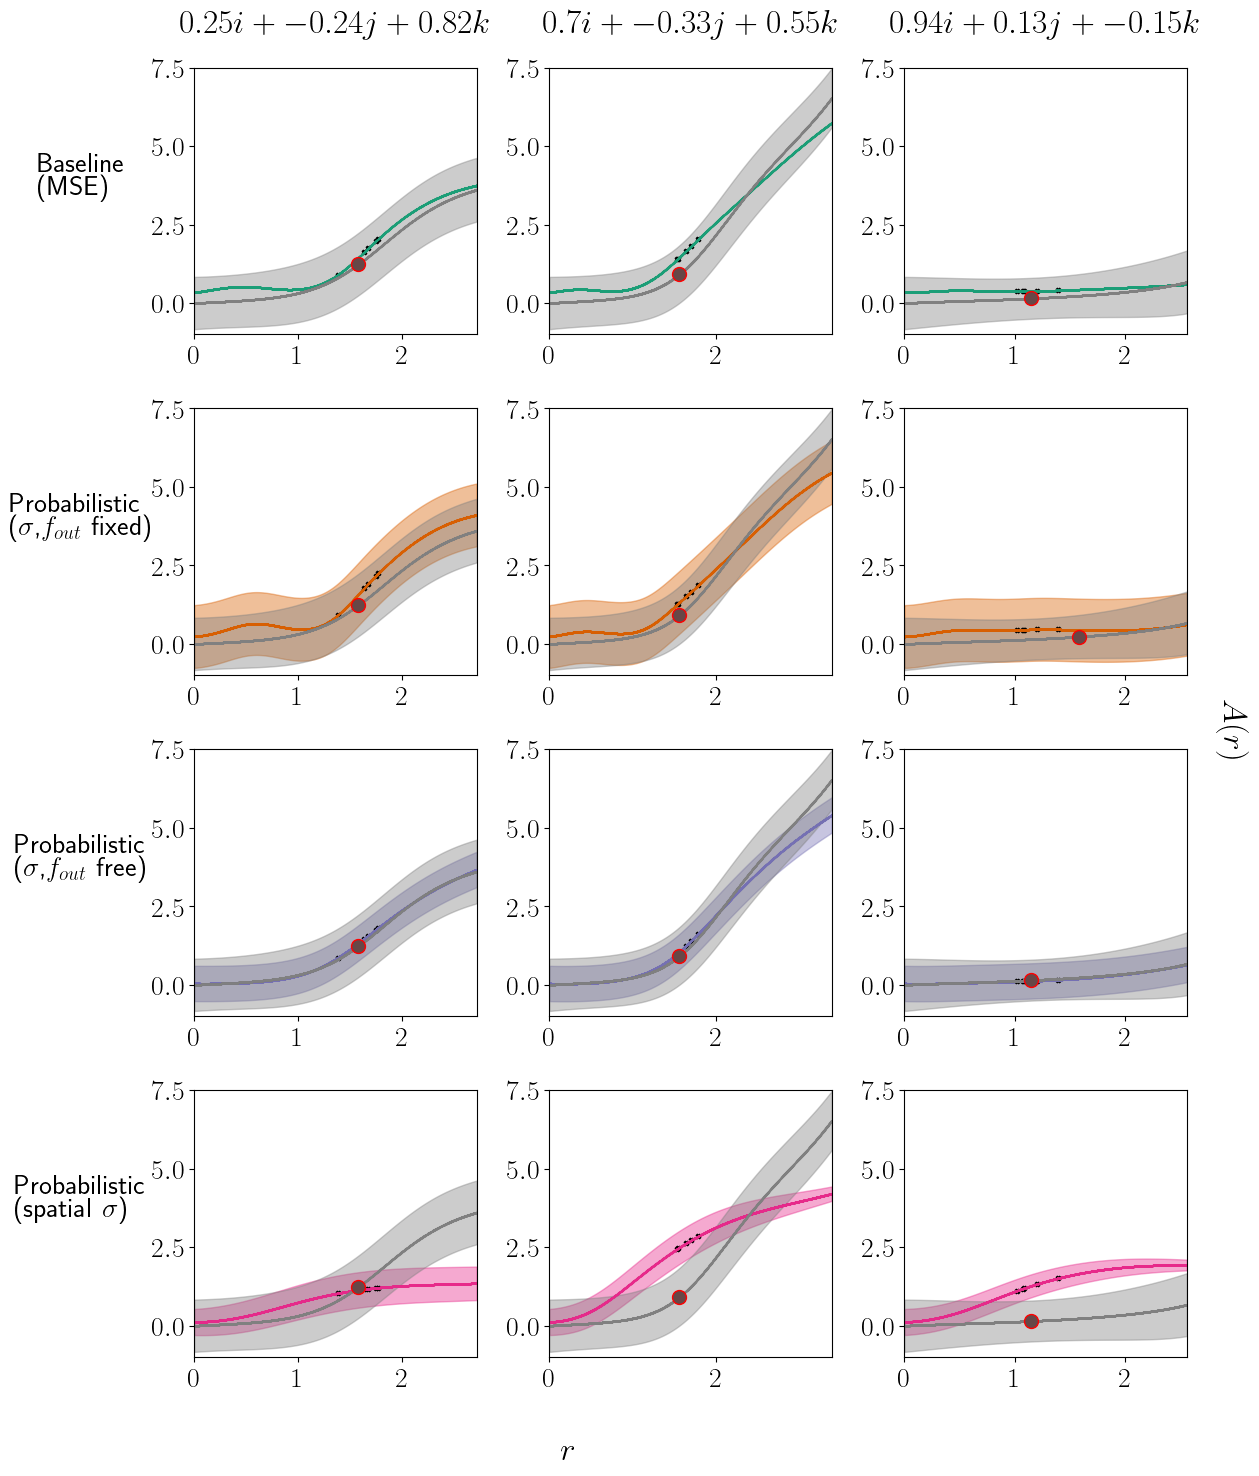

In [122]:
fig = plt.figure(figsize=(13, 15), tight_layout=True)
lims, std_lims = [-1, 10], [0, 0.4] # TODO change this so the range is right
color1, color2, color3, color4 = "#1b9e77", "#d95f02", "#7570b3", "#e7298a" 
fig.supxlabel(r'$r$')
fig.supylabel(r'$A(r)$', ha="right", x=1.025, rotation=270)
# plt.ylim([0, 7.5])

# model A
# TODO: for later change this trueA_los1
pred_along_los(1, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelA_mean, 'A', pred_color=color1, y_label="Baseline\n(MSE)")
pred_along_los(2, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelA_mean, 'A', pred_color=color1)
pred_along_los(3, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelA_mean, 'A', pred_color=color1)

# # model B
pred_along_los(4, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelB_mean, 'B', constantstd=0.2 * 5, pred_color=color2, y_label="Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" fixed)")
pred_along_los(5, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelB_mean, 'B', constantstd=0.2 * 5, pred_color=color2)
pred_along_los(6, i3, samps_los3, A_los3, star_los1_i, std_true_los3, modelB_mean, 'B', constantstd=0.2 * 5, pred_color=color2)

# # # model C
pred_along_los(7, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelC_mean, 'C', constantstd=modelC_final_variable_std * 5, pred_color=color3, y_label="Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" free)")
pred_along_los(8, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelC_mean, 'C', constantstd=modelC_final_variable_std * 5, pred_color=color3)
pred_along_los(9, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelC_mean, 'C', constantstd=modelC_final_variable_std * 5, pred_color=color3)

# # # model D
pred_along_los(10, i1, samps_los1, A_los1, star_los1_i, std_true_los1, modelD_mean, 'D', modelstd=modelD_std, pred_color=color4, y_label="Probabilistic\n(spatial "+r'$\sigma$'+")")
pred_along_los(11, i2, samps_los2, A_los2, star_los2_i, std_true_los2, modelD_mean, 'D', modelstd=modelD_std, pred_color=color4)
pred_along_los(12, i3, samps_los3, A_los3, star_los3_i, std_true_los3, modelD_mean, 'D', modelstd=modelD_std, pred_color=color4)

plt.savefig('plots/4panel_los_2.png', bbox_inches='tight')

1. **DONE** For the truth we'll probably want to pick something like a black/gray so it's easy to overplot different colours over it. We'll want to use a black line for the true mean and a grey shaded region for the uncertainty. We can adjust the alpha as needed to get the right transparency.
2. overplot stars as black scatter points if we wanted to add them in. We would probably want to show exactly what you have plotted (noisy samples, including outliers). The true values will be useful when (re)computing the residual plots you sent around last time.
3. indicate outliers with a different color
4. **DONE** For the four models, we'll want to instead make the same plots but with a set of colourblind-friendly choices (so solid line for mean, lighter shaded region for uncertainty if available). In the original one you sent around you used a red-brown-green-blue pallette, so we can either keep the same or try something like https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=4 (or other online resources) for inspiration.
5. **DONE** I think the current LOS directions that you picked look pretty reasonable! We'll just want to do it by eye from a 3-D plot, most likely.
6. **DONE** You can probably adjust the x-axis range to not extend beyond the reliable line. (We can keep the y-axis range the same.)
7. Get the scatter colour to agree with the mean colour (so light green+ dark green, etc.) instead of using yellow
8. **DONE** And for the gray we want to plot the true scatter along the LOS, so it should be the same in all the plots (rather than now where it’s just the same as the predicted one)
9. **DONE**And in terms of the padding: yes, you have to get rid of the padding in x and y by manually setting the xlim and ylim

NOTE: that we amplify the scatter by a factor of 5 to better see the effect